## Importando e instalando dependências

In [1]:
# colab environment doesnt have torch_snippets
!pip install -q torch_snippets

In [2]:
from torch_snippets import *
import torch
import os
from torchvision    import transforms, models

device = 'cuda' if torch.cuda.is_available() else 'cpu' # colab offers limited gpu acess
print(device)


cuda


### Parte I - Construindo a classe de dataset

Conforme discutido ao longo das aulas, na estrutura do PyTorch, além do modelo em si, uma classe obrigatória é uma de Dataset. Essa é uma classe especificada pelo usuário, mas que herda da classe Dataset do Pytorch. Devemos redefinir 3 métodos dessa classe:



1.   *init*, em que declaramos as variáveis de caminho para a pasta de imagens, caminho para o arquivo de comparações e a função de transformação dos dados (*data augmentation*)
2.   *getitem*. Esse é o método chamado pelo objeto de Dataloader, que será explorado mais a frente. Aqui precisamos retornar **tensores** que representam as imagens de entrada, assim como o **label** (verdadeiro ou falso)
3. len, o qual retorna o tamanho do dataset

**Ao mudar o conjunto de dados de entrada, é fundamental checar se é preciso ou não fazer alterações nessa classe de dataset, já que muda-se, também, o arquivo de comparação de entrada (observe que existe uma manipulação de string no *getitem* especifica para o formato do arquivo *compare_new.txt*. O mesmo acontece quando modifica-se a função de loss para usar a triplet_loss, por exemplo.** 



In [3]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, image_folder, imagenames_file, transform=None):
        self.image_folder    = image_folder
        self.imagenames_file = imagenames_file
        self.nitems          = 0
        self.transform       = transform

        f     = open(self.imagenames_file,"r")
        self.pairs = []
        for line in f:
            pair = line.strip().split(" ")
            self.pairs.append(pair)

        self.nitems = len(self.pairs)

    def __getitem__(self, ix):
        image1      = self.pairs[ix][0]
        image2      = self.pairs[ix][1]
        
        person1 = image1.split("_")[0] # 001_01.png -> 001
        person2 = image2.split("_")[0] # 002_01.png -> 002
        
        if (person1 == person2):
            truelabel = 0
        else:
            truelabel = 1
        
        image1 = read("{}/{}".format(self.image_folder,image1))
        image2 = read("{}/{}".format(self.image_folder,image2))
        image1 = np.expand_dims(image1,2)
        image2 = np.expand_dims(image2,2)
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, np.array([truelabel])
    def __len__(self):
        return self.nitems

Após a definição da classe de dataset, definimos os possíveis objetos de transformação. O *prep* realiza uma preparação inicial nas imagens de modo a padronizar o shape de entrada. O *aug*, além de fazer isso, aplica uma técnica conhecida como *data augmentation*, que serve para evitar o *overfitting*, mas pode aumentar bastante o esforço computacional para treinamento (i.e., ela requer aumento no número de épocas).

Utilize apenas *prep* para conjuntos de validação e de teste. Tanto *prep* quanto *aug* pode ser utilizado para o conjunto de treino

In [4]:
from torchvision.transforms.transforms import ToPILImage
# Regular preprocessing transformation. After being resized, 
# it is converted into a tensor for normalization.

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

prep = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(5, (0.01,0.2),
    #                         scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor()
    # transforms.Normalize((0.5), (0.5))
])

prepVGG = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomAffine(5, (0.01,0.2),
    #                         scale=(0.9,1.1)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
    # transforms.Normalize((0.5), (0.5))
])

aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=15, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0, fillcolor=None, resample=None),
    transforms.CenterCrop(250),
    transforms.Resize((100,100), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor()
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

Em seguida realizamos uma separação dos arquivos de treino e de validação. Basicamente estamos quebrando o arquivo txt de comparações em uma parte de treino e uma parte de validação, ao mesmo tempo que fazemos um *shuffle* nas linhas. 

Um possível experimento é o de mudar o percentual de dados utilizado para treino e para validação. Você pode modificar isso na célula abaixo.

In [6]:
import random
with open("./compare_new.txt", 'r') as fp:
    data = [(random.random(), line) for line in fp]
    dataset_size = len(data)
    train_perc = 0.80
    valid_perc = 0.20
    num_train_samples = int(dataset_size*train_perc)
    num_valid_samples = int(dataset_size*valid_perc)
data.sort()

with open("train_comparisons.txt", 'w') as train:
  for _, line in data[:num_train_samples]:
    train.write(line)

with open("valid_comparisons.txt", 'w') as valid:
  for _, line in data[:num_valid_samples]:
    valid.write(line)



Vamos demonstrar a utilização da classe dataset e visualizar alguns pares de imagem de treinamento.

In [8]:
image_folder = "./regis" # folder with images of a dataset
train_imagenames_file = "./train_comparisons.txt" # csv file with image comparisons for training
valid_imagenames_file = "./valid_comparisons.txt" # csv file with image comparisons for validation

# criação do objeto da classe dataset
dataset    = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = train_imagenames_file, transform=aug)



Number of images: 4
Images are 100x100x1


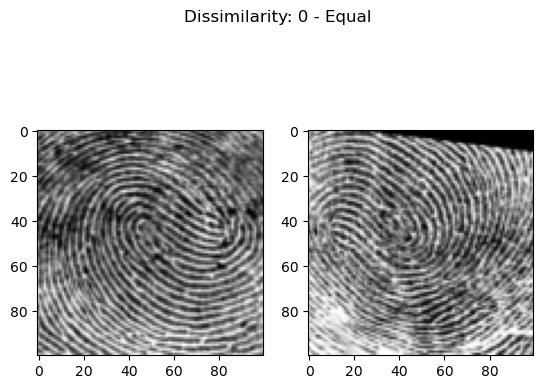

In [9]:
print("Number of images: {}".format(len(dataset)))

# obtendo uma amostra aleatória do conjunto de dados
sample = random.randint(0, len(dataset))
image1, image2, label = dataset[sample]

# Visualizando as duas imagens de entrada, bem como o label
nchannels = image1.shape[0]
height    = image1.shape[1]
width     = image1.shape[2]

print("Images are {}x{}x{}".format(width,height,nchannels))

image1 = image1.squeeze()
image2 = image2.squeeze()


# Plotting images
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].imshow(image1, cmap='gray')
ax[1].imshow(image2, cmap='gray')
dissimilarity_text = 'Different' if label[0] else 'Equal'
plt.suptitle('Dissimilarity: {} - {}'.format(label[0], dissimilarity_text))
plt.subplots_adjust(hspace=0.5)
plt.show()


Essa é uma demonstração básica de como utilizar a classe Dataset. Sinta-se livre para realizar diferentes experimentos nesta seção. A construção do Dataset é tão impactante quanto o modelo em si em tarefas de *Deep Learning*.

## Parte II - Construindo a arquitetura da rede

Nas células abaixo, criamos uma rede convolucional simples que deve servir como *baseline* para os seus experimentos. Observe a classe *SiameseNetwork* - ela demonstra o processo de criação básico no PyTorch. Toda rede é implementada como uma classe que herda do *nn.Module*, e deve possuir 2 métodos obrigatórios:



*   *init*: aqui definimos as camadas da rede. Nessa rede possuímos 2 blocos convolucionais (extratores de características), uma camada de *Flatten* e 3 camadas lineares (redutores de dimensionalidade). Perceba que utilizamos a função *convBlock* para definir um bloco convolucional (que em si, também é uma classe do *nn.Module*).
*   *forward*: esse método redefine o método *call* da classe. Ou seja, ao invocarmos um *SiameseNetwork()(parameters)*, estamos chamando a função *forward* definida abaixo. Enquanto o *init* define as camadas da rede, **o *forward* define como essas camadas se conectam para gerar um vetor de atributos na saída**. 

Para maiores referências, utilize a prórpria documentação do PyTorch. Uma dica é a utilização, também, do livro *Modern Computer Vision with PyTorch* (https://www.amazon.com.br/Modern-Computer-Vision-PyTorch-applications/dp/1839213477).



In [10]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size=3, padding=1, bias=False), #, padding_mode='reflect'),
        nn.BatchNorm2d(no),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,16),
            convBlock(16,128),
            nn.Flatten(),
            nn.Linear(128*25*25, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

Uma outra opção é o de utilizar um *backbone* de uma rede pré-treinada, como a VGG. Perceba as mudanças que ocorrem na declaração do self.features. Estamos utilizando apenas as camadas convolucionais da rede VGG (você pode inspecionar as camadas da rede vgg utilizando o método *children*). Trata-se de uma rede convolucional bem mais profunda, o que também requer mais processamento.

As camadas iniciais devem ser "congeladas", ou seja, seus pesos não alterarão durante o processo de *backpropagation*. Se você quiser utilizar essa outra rede, é importante prestar atenção e utilizar o conjunto de transformações "prepVGG" (no DataLoader), definido na parte I, já que as camadas convolucionais da VGG esperam um input_shape de (224,224). 

In [12]:
class SiameseNetworkVGGBackbone(nn.Module):
    def __init__(self):
        super(SiameseNetworkVGGBackbone, self).__init__()
        self.features = nn.Sequential(*list(models.vgg16(pretrained=True).children())[:-1])
        for param in self.features.parameters():
          param.requires_grad = False
      
        self.dimensionality_reductor = nn.Sequential(
            nn.Flatten(),
            models.vgg16(pretrained=True).classifier[0],
            nn.Linear(4096, 512), nn.ReLU(inplace = True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64)
        )


    def forward(self, input1, input2):
        output1 = self.features(input1)
        output1 = self.dimensionality_reductor(output1)
        output2 = self.features(input2)
        output2 = self.dimensionality_reductor(output2)

        return output1, output2

Em seguida, definimos a função de loss (ContrastiveLoss) e funções para realização do treino e da validação.

A função de treino é uma implementação direta do algoritmo de treinamento de uma rede neural:


1.   Para cada batch de dados, aplicamos o *forward* da rede
2.   Computa-se a loss
3.   Atualiza-se os pesos da rede por meio do *back propagation*

Perceba que, embora "maior" do que um script de treino de uma rede no TensorFlow, o PyTorch permite mais flexibilidade ao usuário no processo de treinamento.



In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)/2 +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))/2
        acc = ((euclidean_distance > contrastive_thres) == label).float().mean()
        return loss_contrastive, acc


def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc =     criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

def valid_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]

    model.eval() # put the model in evaluation mode
    codesA, codesB = model(imgsA, imgsB) # predict the output for the batch
    loss, acc  = criterion(codesA, codesB, labels) # compute loss, both inputs must have the same sizes
    model.train()
    
    return loss.item(), acc.item()


## Parte III - Treino da rede

É importante iniciar esta seção destacando a necessidade de utilização do objeto do PyTorch chamado de DataLoader, que recebe como entrada um objeto da classe Dataset. Esse objeto realiza o agrupamento dos dados em *batches*, o que impacta bastante o processo de treinamento. A função *GetBatches* abaixo ilustra a utilização do DataLoader.

Iniciamos o script de treino definindo os objetos de DataLoader de treino e de validação.

In [17]:
batchsize = 1 # defina um batch maior quando tiver mais imagens

def GetBatches(image_folder, image_names, batchsize, transformation):
    datatensor = SiameseNetworkDataset(image_folder, image_names, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

# as transformations, you may choose None, prep, or aug. However, aug applies to the training set only
trainload = GetBatches(image_folder, train_imagenames_file, batchsize, aug)  
validload = GetBatches(image_folder, valid_imagenames_file, batchsize, prep)

# trainload = GetBatches(image_folder, train_imagenames_file, batchsize, prepVGG)  # descomentar essa parte se for usar o backbone da VGG
# validload = GetBatches(image_folder, valid_imagenames_file, batchsize, prepVGG)

print("Quantidade de batches de treino: ", len(trainload))
print("Quantidade de batches de validação: ", len(validload))


Quantidade de batches de treino:  4
Quantidade de batches de validação:  1


In [18]:
inspect(next(iter(trainload))) # inspect a couple of items in the batches

List Of 3 items
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.094	Max: 1.000	Mean: 0.590	dtype: torch.float32
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.000	Max: 1.000	Mean: 0.499	dtype: torch.float32
	Tensor	Shape: torch.Size([1, 1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64


Em seguida instanciamos os objetos do modelo, do *criterion* (loss) e do otimizador. O script de treino é dado logo abaixo.

**Esse é o momento mais necessário para a utilização da GPU**.

Você pode avaliar também o modelo FPNet.pth em ./models, que foi prétreinado em outra base. Neste caso, carregando o modelo, o treinamento será um refinamento de seus pesos. 


In [88]:
model      = torch.load("./models/FPNet.pth", map_location=device)
# model      = SiameseNetwork().to(device)
# model      = SiameseNetworkVGGBackbone().to(device)

criterion  = ContrastiveLoss()
optimizer  = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.01)
nepochs    = 5 # default training value was 200, but requires a lot of time

contrastive_thres = 1.1


EPOCH: 5.000	val_loss: 0.862	val_acc: 0.000	(0.41s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 89582.15it/s]
2022-05-30 10:32:05.284 | INFO     | torch_snippets.torch_loader:plot_epochs:135 - metric val_loss was not fully recorded. Plotting final epochs using last recorded value
2022-05-30 10:32:05.285 | INFO     | torch_snippets.torch_loader:plot_epochs:135 - metric val_acc was not fully recorded. Plotting final epochs using last recorded value


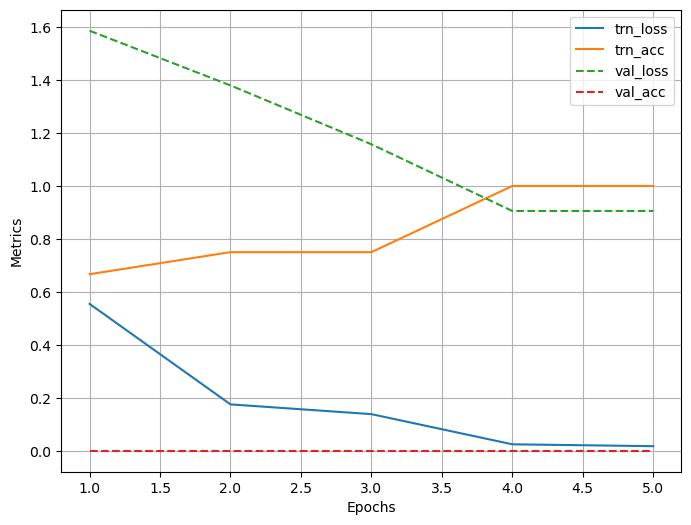

In [83]:
log     = Report(nepochs)
for epoch in range(nepochs):
    N = len(trainload)
    for i, data in enumerate(trainload):
        batch_loss, batch_acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=batch_loss, trn_acc=batch_acc, end='\r')

    N = len(validload)
    with torch.no_grad():
        for i, data in enumerate(validload):
            batch_loss, batch_acc = valid_batch(model, data, criterion)
            log.record(epoch+(1+i)/N, val_loss=batch_loss, val_acc=batch_acc, end='\r')  
log.plot_epochs()       

Não esqueça de salvar os modelos após o treinamento! 

In [89]:
torch.save(model.state_dict(), "saved_model_state_dict.pth")

## Parte IV -  Avaliação do modelo treinado

Após o treino do modelo, devemos visualizar como ele é capaz de generalizar para novos dados. 



In [90]:
# Se já possui um modelo treinado, carregue os pesos
model_path = './saved_model_state_dict.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

SiameseNetwork(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=80000, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=256, out_features=64, bias=True)
  )
)

Novamente definimos os caminhos para as pastas de imagens e arquivo de comparação do novo conjunto de dados. Utilize uma base de dados diferente da que foi utilizada para o treino. Por exemplo, divida compare_new.txt em duas bases, para treino e teste, e use a primeira para gerar o modelo, conforme indicado acima, e a segunda para teste. 

In [91]:
test_image_folder = "./regis"  
test_imagenames_file = "compare_new.txt" # mude para o arquivo de teste
testload = GetBatches(test_image_folder, test_imagenames_file, batchsize, prep)
inspect(next(iter(testload)))

List Of 3 items
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.008	Max: 1.000	Mean: 0.473	dtype: torch.float32
	Tensor	Shape: torch.Size([1, 1, 100, 100])	Min: 0.027	Max: 1.000	Mean: 0.576	dtype: torch.float32
	Tensor	Shape: torch.Size([1, 1])	Min: 0.000	Max: 0.000	Mean: 0.000	dtype: torch.int64


Percorremos todos os batches do conjunto de teste e calculamos a loss e a acurácia.

In [92]:
#put model in evaluation mode
model.eval()

Acc = []
Loss = []

#process all batches
for ix, data in enumerate(testload):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    with torch.no_grad():
      codesA, codesB       = model(imgsA, imgsB)

      loss, acc            = criterion(codesA, codesB, labels)
      Acc.append(acc.detach().cpu().numpy())
      Loss.append(loss.detach().cpu().numpy())


# Como o dataset é desbalanceado, talvez seja interessante propor e 
# explorar outras métricas que não sejam apenas a acurácia e a Loss para a validação!
print('Acurácia no conjunto de teste: {:.6f}'.format(np.mean(Acc)))
print('Loss no conjunto de teste: {:.6f}'.format(np.mean(Loss)))



 

Acurácia no conjunto de teste: 0.600000
Loss no conjunto de teste: 0.559900


Além da acurácia no conjunto de testes, é interessante visualizar se o modelo consegue gerar um resultado de distância pequeno para um par de imagens do mesmo indivíduo e uma distância grande para um par de imagens de indivíduos diferentes.

Lembre-se que o que a rede está aprendendo é justamente a calcular uma distância entre *fingerprints*: digitais iguais devem possuir uma distância próxima de 0 e digitais diferentes devem possuir uma distância grande.

Sendo esse o caso, podemos percorrer todo o nosso dado e calcular a distância dada pela rede para as duas classes (digitais iguais e digitais diferentes). Em seguida visualizamos os histogramas das distribuições. Caso o modelo tenha sido capaz de aprender bem, as duas distribuições devem estar bem separadas.

In [99]:
# Distance histogram
different = []
same = []
model.eval()

image_folder = './regis'
imagenames_file = './compare_new.txt'

dataset       = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = imagenames_file, transform=prep)

dataloader    = DataLoader(dataset,batch_size=1,shuffle=True)

for ix, data in enumerate(dataloader):
  if (ix + 1)%1000 == 0:
    print('Processing batch {}/{}'.format((ix + 1), len(dataloader)))
  imgsA, imgsB, labels = [t.to(device) for t in data]
  codesA, codesB       = model(imgsA, imgsB)

  with torch.no_grad():
    euclidean_distance        = F.pairwise_distance(codesA, codesB)
    if (labels == 0): # same person
      same.append(euclidean_distance.item())
    else:
      different.append(euclidean_distance.item())


In [100]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Histograma de distâncias para as duas classes', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('Distância Euclidiana', fontsize = 16, fontweight = 'bold')
ax.set_ylabel('Densidade', fontsize = 16, fontweight = 'bold')
ax.hist(different,bins = 50, alpha = 0.7, label = 'different')
ax.hist(same, bins = 50, alpha = 0.7, label = 'same')
ax.tick_params(labelsize = 16, axis = 'both')
ax.legend()
ax.grid(True)
plt.plot()

[]

Que conclusões podemos tirar desse histograma básico? O modelo foi capaz de separar bem as duas classes ?

## Parte V - Deploy

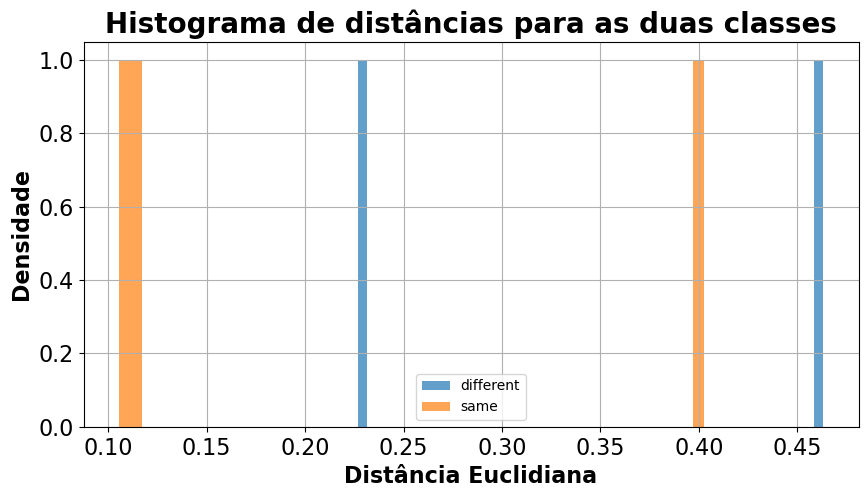

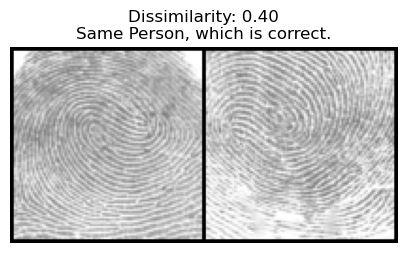

In [ ]:
model.eval()
do_comparison = 'y'

image_folder = './regis'
imagenames_file = './compare_new.txt'

dataset       = SiameseNetworkDataset(image_folder=image_folder, imagenames_file = imagenames_file, transform=prep)

dataloader    = DataLoader(dataset,batch_size=1,shuffle=True)

while(do_comparison=='y'):
    dataiter                  = iter(dataloader)
    image1, image2, truelabel = [t.to(device) for t in next(dataiter)]
    concatenated              = torch.cat((image1*0.5+0.5, image2*0.5+0.5),0)

    output1,output2           = model(image1,image2)
    euclidean_distance        = F.pairwise_distance(output1, output2)
    if (euclidean_distance.item() <= contrastive_thres):
        if (truelabel != 0):
            output = 'Same Person, which is an error.'
        else:
            output = 'Same Person, which is correct.'
    else:
        if (truelabel == 0):
            output = 'Different, which is an error.'
        else:
            output = 'Different, which is correct.'
    
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()
    do_comparison = input("Type y to continue: ")
